In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [17]:
def plant(y, y_prev, u):
    return 0.3*y + 0.6*y_prev + (0.6*np.sin(np.pi*u) + 0.3*np.sin(3*np.pi*u) + 0.1*np.sin(5*np.pi*u))

In [18]:
class NeuralNetwork:
    
    def __init__(self, input_size, hidden_layer_neurons, output_size):
        np.random.seed(2)
        
        self.number_of_layers = len(hidden_layer_neurons) + 2                           # hidden + input + output
        self.input_size = input_size
        self.hidden_layers_neurons = hidden_layer_neurons                               # neurons per hidden layer
        self.output_size = output_size
        self.layers = [input_size] + hidden_layer_neurons + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) for i in range(self.number_of_layers - 1)]
        self.biases = [np.ones((1, layer)) for layer in self.layers[1:]]
        self.loss_list = []
        self.activations = None
    
    
    def __activation__(self, z):
        # return np.maximum(0, z)
        return np.tanh(z)

    
    def __activation_deriv__(self, z):
        # return np.where(z > 0, 1, 0)
        return 1 - np.tanh(z)**2
        
        
    def __compute_loss__(self, X, y):
        final_loss = 0
        
        for x_element, y_element in zip(X, y):
            x_element = x_element.reshape(self.input_size, 1)
            y_element = y_element.reshape(self.output_size, 1)
            output_forward = self.__forward__(x_element)
            
            loss = 0.5 * np.sum(( y_element - output_forward) ** 2)
            final_loss += loss
            
        self.loss_list.append(final_loss)
            
    
    def __forward__(self, X):
        self.activations = [X]
        
        for weight, bias in zip(self.weights, self.biases):
            z = np.matmul(weight.T, self.activations[-1]) + bias.T
            a = self.__activation__(z)    
            self.activations.append(a)
            
        return self.activations[-1]
    
    
    def __backward__(self, y):
        deltas = [None] * len(self.weights)                 
        delta =  self.activations[-1] - y
        
        deltas[-1] = delta * self.__activation_deriv__(self.activations[-1])

        for i in reversed(range(len(deltas) - 1)):
            error = np.matmul(self.weights[i+1], deltas[i+1])   
            deltas[i] = error * self.__activation_deriv__(self.activations[i+1])


        for i in range(len(self.weights)):
            self.weights[i] -= np.matmul(self.activations[i], deltas[i].T) * self.learning_rate 
            self.biases[i] -= np.sum(deltas[i], axis=0, keepdims=True) * self.learning_rate

        
    def train(self, X, y, learning_rate, epochs):
        self.learning_rate = learning_rate
        
        for epoch in range(epochs):
            for x_element, y_element in zip(X, y):
                x_element = x_element.reshape(self.input_size, 1)
                y_element = y_element.reshape(self.output_size, 1)
                self.__forward__(x_element)
                self.__backward__(y_element)
            self.__compute_loss__(X, y)
            
        return self.loss_list, self.weights, self.biases
            
    
    def test_model(self, X):
        output = self.__forward__(X)
        output = np.round(output, 4).reshape(self.output_size).tolist()

        return output
                
    
    def describe_model(self):
        """ for testing purpose """
        
        print("Number of Layers: ", self.number_of_layers)
        print("Input Size: ", self.input_size)
        print("Output Size: ", self.output_size)
        print("Weights Shape: \n")
        for w in self.weights:
            print(w.shape)
        print("Biases Shape: \n")
        for b in self.biases:
            print(b.shape)

# Get K, U, Y

In [19]:
num_samples = 500
  
k_values = np.arange(num_samples)
u_values = np.sin(2*np.pi*k_values/250)
y_values = np.zeros(num_samples)

for k in range(2, num_samples):
    y_values[k] = plant(y_values[k-1], y_values[k-2], u_values[k])

# Train Neural Network 

In [20]:
np.random.seed(7)

input_size = 1
hidden_layer_neurons = [20, 10]
output_size = 1
learning_rate = 0.5
epochs = 500

X = u_values.reshape(num_samples, 1)
y = y_values.reshape(num_samples, 1)

model = NeuralNetwork(input_size, hidden_layer_neurons, output_size)
loss, weights, biases = model.train(X, y, learning_rate, epochs)

In [21]:
op = []

for index in range(len(X)):
    x_ele = X[index]
    x_ele = x_ele.reshape(input_size, 1)
    output = model.test_model(x_ele)
    
    if index == 0:
        output = 0.3*y_values[index] + output[0]
    else:
        output = 0.3*y_values[index] + 0.6*y_values[index-1] + output[0]
        
    op.append(output)

# Plot Output

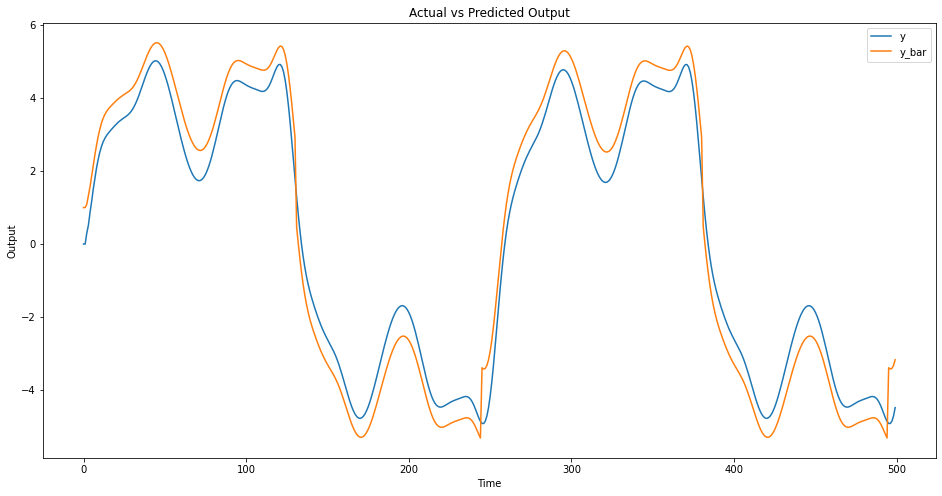

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(k_values, y_values, label='y')
plt.plot(k_values, op, label='y_bar')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Actual vs Predicted Output')
plt.legend()
plt.savefig("./Images/Example_1_Actual_vs_Predicted.pdf")
plt.show()